In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import generative as gen
import numpy as np
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from utils import NetworkOptimizer, fast_evaluator

In [3]:
res_parcellation = 0
consensus_mat = scipy.io.loadmat(
    "datasets/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
euclidean_dis = squareform(pdist(coordinates, metric='euclidean'))

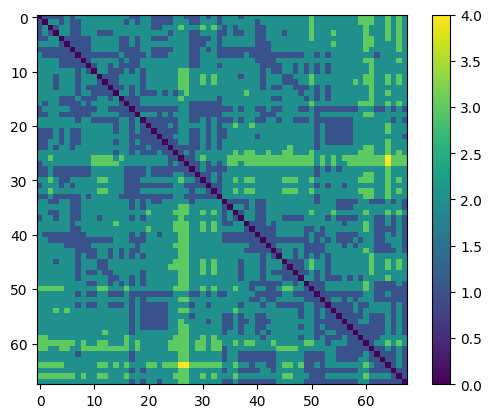

In [10]:
plt.imshow(gen.shortest_path_distance(connectivity, coordinates))
plt.colorbar()

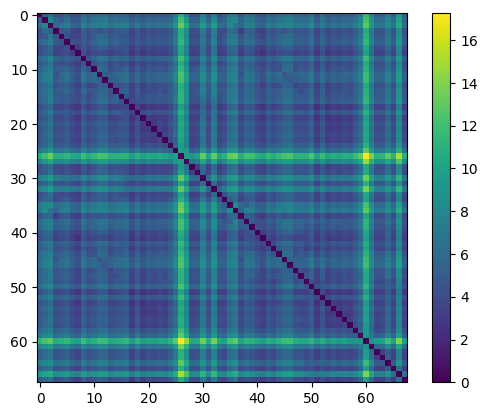

In [4]:
plt.imshow(gen.resistance_distance(connectivity, coordinates))
plt.colorbar()

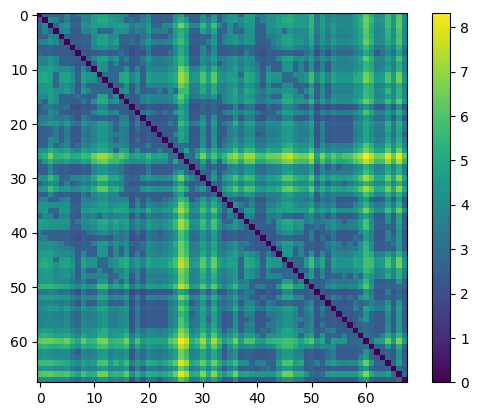

In [6]:
plt.imshow(gen.propagation_distance(connectivity, coordinates))
plt.colorbar()

In [99]:
optimizer = NetworkOptimizer(
        coordinates=coordinates,
        empirical_network=connectivity,
        n_iterations=2600,
        random_seed=11
    )
    
# Define parameter ranges
param_ranges = {
    'alpha': (0.8, 2),
}

# Run optimization
results = optimizer.optimize(
    param_ranges=param_ranges,
    n_calls=30,
    n_parallel_samples=1,
    verbose=True
)

Running Bayesian optimization...


Simulating network evolution: 100%|██████████| 2599/2599 [00:07<00:00, 366.90it/s]


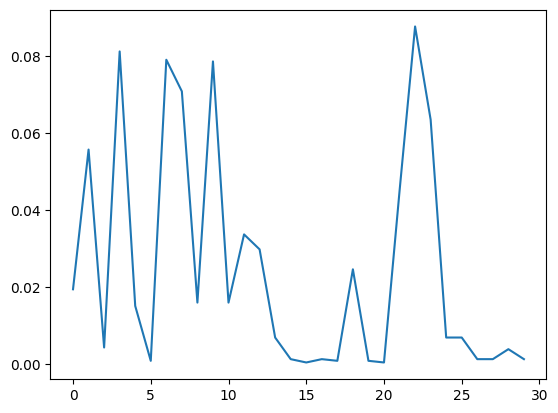

In [100]:
plt.plot(results.all_scores)

In [101]:
results.best_parameters

{'alpha': 1.0661791606374877}

In [111]:

# Create parameter trajectories
n_iterations = 2500
n_nodes = connectivity.shape[0]
alpha = np.full(n_iterations, results.best_parameters["alpha"])
beta = np.full(n_iterations, 0.1)
noise = np.zeros(n_iterations)
penalty = np.zeros(n_iterations)

# Run simulation
history = gen.simulate_network_evolution(
    coordinates=coordinates,
    n_iterations=n_iterations,
    alpha=alpha,
    beta=beta,
    noise=noise,
    distance_fn=gen.resistance_distance,
    connectivity_penalty=penalty,
    n_jobs=-1,  # Use all available cores
    random_seed=42,
    batch_size=32,
)

Simulating network evolution: 100%|██████████| 2499/2499 [01:24<00:00, 29.71it/s]


In [112]:
np.sum(history[:,:,-1])/(connectivity.shape[0])**2

0.2772491349480969

In [113]:
np.sum(connectivity)/(connectivity.shape[0])**2

0.2772491349480969

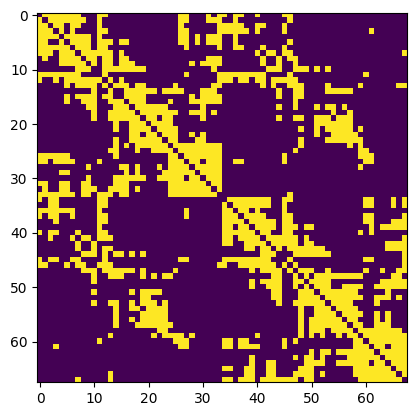

In [114]:
plt.imshow(history[:,:,-1])

In [115]:
energy_vector = np.zeros(history.shape[2])
clustering_vector = np.zeros(history.shape[2])
betweenness_vector = np.zeros(history.shape[2])
distance_vector = np.zeros(history.shape[2])
degrees_vector = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    res = fast_evaluator(history[:,:,t], connectivity, euclidean_dis)
    energy_vector[t] = res["energy"]
    clustering_vector[t] = res["ks_clustering"]
    betweenness_vector[t] = res["ks_betweenness"]
    distance_vector[t] = res["ks_distance"]
    degrees_vector[t] = res["ks_degrees"]

Evaluating network evolution:   0%|          | 0/2500 [00:00<?, ?it/s]

Evaluating network evolution: 100%|██████████| 2500/2500 [00:08<00:00, 296.29it/s]


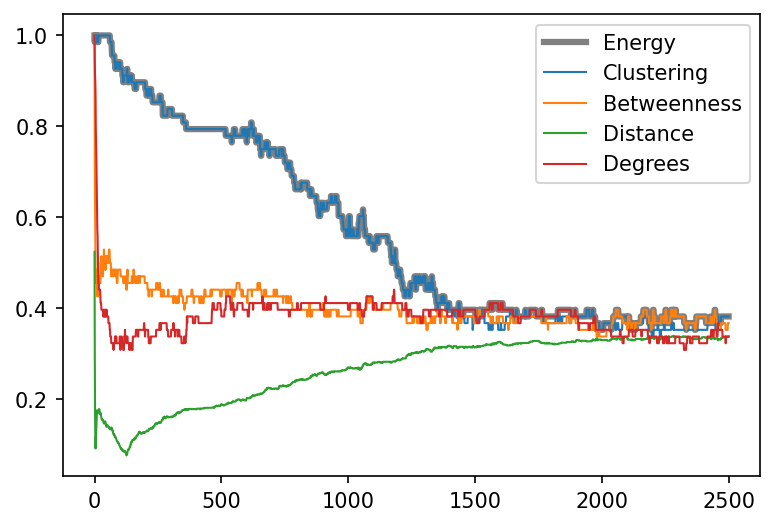

In [116]:
plt.figure(figsize=(6, 4),dpi=150)
plt.plot(energy_vector,lw=3,label='Energy',color='gray')
plt.plot(clustering_vector,lw=1,label='Clustering')
plt.plot(betweenness_vector,lw=1,label='Betweenness')
plt.plot(distance_vector,lw=1,label='Distance')
plt.plot(degrees_vector,lw=1,label='Degrees')
plt.legend();

In [117]:
np.min(energy_vector)

0.35294117647058826

In [118]:
np.argmin(energy_vector)

1980

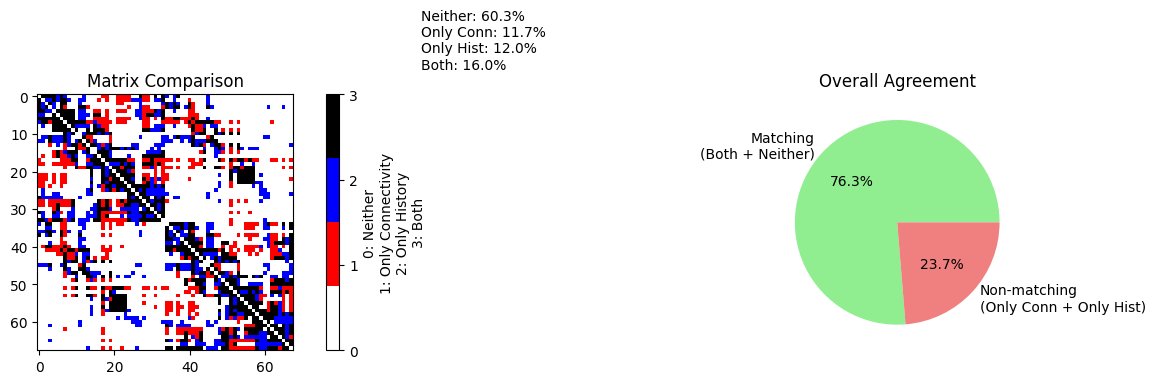

In [119]:
# Create a figure
plt.figure(figsize=(15, 4))

# Get the time point with minimum energy
min_energy_point = np.argmin(energy_vector)

# Create subplots
plt.subplot(121)
# Create a custom matrix where:
# 0: neither (white)
# 1: only connectivity (red)
# 2: only history (blue)
# 3: both (black)
comparison = connectivity.astype(int) + 2 * history[:,:,min_energy_point].astype(int)
plt.imshow(comparison, cmap=plt.cm.colors.ListedColormap(['white', 'red', 'blue', 'black']))
plt.title('Matrix Comparison')
plt.colorbar(ticks=[0, 1, 2, 3], 
            label='0: Neither\n1: Only Connectivity\n2: Only History\n3: Both')

# Add percentage text
total = connectivity.shape[0] * connectivity.shape[1]
neither = np.sum(comparison == 0) / total * 100
only_conn = np.sum(comparison == 1) / total * 100
only_hist = np.sum(comparison == 2) / total * 100
both = np.sum(comparison == 3) / total * 100

plt.text(1.5, 1.1, f'Neither: {neither:.1f}%\nOnly Conn: {only_conn:.1f}%\n'
         f'Only Hist: {only_hist:.1f}%\nBoth: {both:.1f}%', 
         transform=plt.gca().transAxes)

# Add second subplot for overlap percentage
plt.subplot(122)
labels = ['Matching\n(Both + Neither)', 'Non-matching\n(Only Conn + Only Hist)']
values = [(both + neither), (only_conn + only_hist)]
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Overall Agreement')

plt.tight_layout()

Evaluating network evolution:   0%|          | 0/2500 [00:00<?, ?it/s]

Evaluating network evolution: 100%|██████████| 2500/2500 [00:01<00:00, 1704.45it/s]


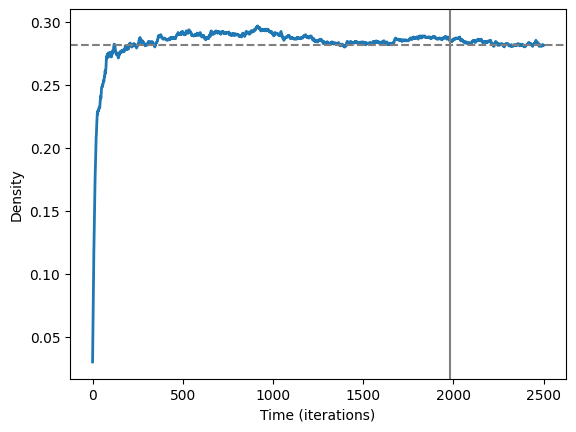

In [120]:
density = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    density[t] = nx.density(nx.from_numpy_array(history[:,:,t]))

plt.plot(density,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Density")
empirical_density = nx.density(nx.from_numpy_array(connectivity))
plt.axhline(empirical_density, color='gray', linestyle='--')
plt.axvline(np.argmin(energy_vector), color='gray', linestyle='-')


In [82]:
import seaborn as sns

In [91]:
history[:,:,-1].astype(int).shape

(68, 68)

In [92]:
connectivity.astype(int).shape

(68, 68)

/var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_39439/2592478079.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


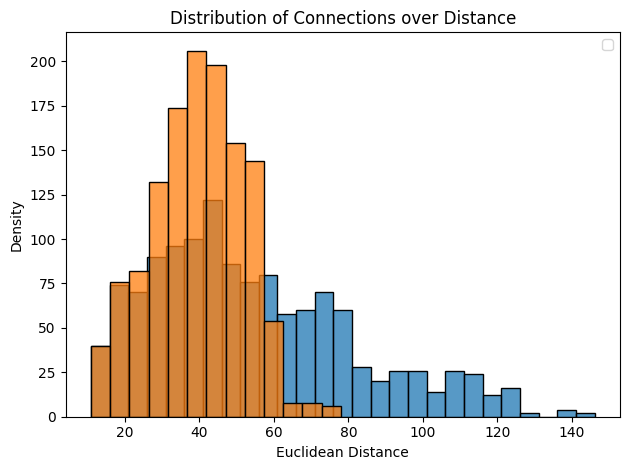

In [121]:
sns.histplot(euclidean_dis[connectivity],binwidth=5)
what = history[:,:,-1].astype(bool)
sns.histplot(euclidean_dis[what],binwidth=5)

plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.title('Distribution of Connections over Distance')
plt.legend()

plt.tight_layout()

In [95]:
what

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [96]:
connectivity

array([[False,  True,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True,  True, False]])